In [1160]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import block_diag

plt.close('all')

Loading the data

In [1161]:
data = np.load('data_point_land_1.npz', allow_pickle=True)

#print(data.files)

Meas = data['Meas'] #Landmark measurements
Uf = data['Uf'] #measured forward velocity (odometry)
Ua = data['Ua'] #measured angular velocity (odometry)
Q = data['Q']
Qturn = data['Qturn']
R = data['R']
Nland = data['Nland'] #number of Landmarks
Ts = data['Ts']
Wturn = data['wturn'] #treshold Wturn
Pose = data['Pose'] #data to be used only for comparison (x(t), y(t), theta(t) of the robot)
Landmarks = data['Landmarks'] #data to be used only for comparison (ith row corresponds to i+1th of landmark locations.)

In [1162]:
print(Pose)

[[ 1.          1.          0.        ]
 [ 1.5         1.          0.        ]
 [ 2.          1.          0.        ]
 [ 2.5         1.          0.        ]
 [ 3.          1.          0.        ]
 [ 3.5         1.          0.        ]
 [ 4.          1.          0.        ]
 [ 4.5         1.          0.        ]
 [ 5.          1.          0.        ]
 [ 5.5         1.          0.        ]
 [ 6.          1.          0.        ]
 [ 6.5         1.          0.        ]
 [ 7.          1.          0.        ]
 [ 7.5         1.          0.        ]
 [ 8.          1.          0.        ]
 [ 8.5         1.          0.        ]
 [ 9.          1.          0.        ]
 [ 9.5         1.          0.        ]
 [10.          1.          0.        ]
 [10.5         1.          0.        ]
 [11.          1.          0.        ]
 [11.5         1.          0.        ]
 [12.          1.          0.        ]
 [12.5         1.          0.        ]
 [13.          1.          0.        ]
 [13.5         1.        

In [1163]:
range_land = Meas.item()['range'] #landmark ranges
angle_land = Meas.item()['angle']  #landmark angles
index_land = Meas.item()['land']  #landmark indices

Angle Wrapping Function

In [1164]:
def angle_wrap(angle):
    angle = (angle + np.pi) % (2 * np.pi) - np.pi
    return angle

def innovation(M, xp):
    # x = xp[0]
    # y = xp[1]
    # theta = xp[2]
    landmarks = M[:, 2]

    # take the predictions
    predicted_meas = np.zeros((len(landmarks), 2))
    
    for i in range(len(landmarks)):
        j = int(landmarks[i] - 1)

        lx = xp[n_upper + 2*j]
        ly = xp[n_upper + 2*j + 1]
        
        predicted_p = np.sqrt((lx - xp[0])**2 + (ly - xp[1])**2)
        predicted_alpha = angle_wrap(np.arctan2(ly - xp[1], lx - xp[0]) - xp[2])
        predicted_meas[i][0] = predicted_p
        predicted_meas[i][1] = predicted_alpha
    
    inn = M[:, :2] - predicted_meas
    return inn.reshape(-1,1)

Initialising

In [1165]:
N = Uf.shape[0] #Number of odometry measurements

n_upper = 3 #upper system order: x,y,theta
n_lower = Nland.item()*2 #lower system order: 2 for every landmark (x,y)
n = n_upper + n_lower  #system order

x0 = np.zeros(n) #initial states
x0[0] = Pose[0,0] #x(0)
x0[1] = Pose[0,1] #y(0)
x0[2] = Pose[0,2] #theta(0)
#upper covariance
lambda_ = 0.01
P_upper = lambda_ * np.eye(n_upper) #uncertainty of x,y,theta
upper_zeros = np.zeros((n_upper,n_lower))
#lower covariance
eta = 1000000
P_lower = eta * np.eye(n_lower) #uncertainty landmarks
lower_zeros = np.zeros((n_lower,n_upper))
#Initial covariance
P0 = np.block([[P_upper,upper_zeros],
              [lower_zeros,P_lower]])
Xp = x0.copy()
Pp = P0.copy()

In [1166]:
print(Q)
print('----------------')
print(Qturn)

[[1.00000000e-02 0.00000000e+00]
 [0.00000000e+00 7.61543549e-05]]
----------------
[[0.01       0.        ]
 [0.         0.06853892]]


EKF loop

In [1167]:
Xp = x0.copy()
Pp = P0.copy()
X_pred = np.empty((N,n))
P_pred = np.empty((N,n))
X_pred[0, :] = Xp
i = 0

turn = Qturn[1][1]
straight = Q[1][1]


Q_straight = Q.copy()
switched = False

checked_landmarks = []
wait_time = 15
print('x: ', Xp[0])
print('y: ', Xp[1])
print('----------------')
while i < N:

    """
        ########### Correction ###########
        
        Find the landmark and correct
        We need two Jacobians
    """

    old = [] # already initialized, needs to make correction
    new = []


    for l in range(len(index_land[i])):
        if index_land[i][l] in checked_landmarks: # first make it like this in order to build the logic
            old.append(l)
        else:
            checked_landmarks.append(index_land[i][l])
            new.append(l)



    # these arrays will store the measurements for the old(already initialized) positions
    to_be_corrected_range = []
    to_be_corrected_angle = []
    to_be_corrected_index = []
    for m in old:
        to_be_corrected_range.append(range_land[i][m])
        to_be_corrected_angle.append(angle_land[i][m])
        to_be_corrected_index.append(index_land[i][m])

    to_be_init_range = []
    to_be_init_angle = []
    to_be_init_index = []
    for m in new:
        to_be_init_range.append(range_land[i][m])
        to_be_init_angle.append(angle_land[i][m])
        to_be_init_index.append(index_land[i][m])
        
    for k in range(len(to_be_init_range)):

        j = to_be_init_index[k] - 1 
        mp = to_be_init_range[k]
        ma = to_be_init_angle[k]

        lx = Xp[0] + mp * np.cos(Xp[2] + ma)
        ly = Xp[1] + mp * np.sin(Xp[2] + ma)
        Xp[n_upper + 2*j] = lx  
        Xp[n_upper + 2*j + 1] = ly  
    
    # first make it for checked as they are not checked

    if to_be_corrected_range:
        H = np.zeros((len(to_be_corrected_range)*2, n))
        for k in range(len(to_be_corrected_range)):
            # landmarks are from 1, so when we see landmark 1 it means that it will
            # be on the 0 position after x, y, theta - Lx = 3, Ly = 4
            j = to_be_corrected_index[k] - 1 

            lx = Xp[n_upper + 2*j]
            ly = Xp[n_upper + 2*j + 1]

            row_p = k*2
            row_alpha = k*2 + 1
            # derivatives with respect to m_p
            p_den = np.sqrt((lx - Xp[0])**2 + (ly - Xp[1])**2) 

            H[row_p][0] = (Xp[0] - lx)/p_den # dx
            H[row_p][1] = (Xp[1] - ly)/p_den # dy
            H[row_p][2] = 0 # dtheta
            H[row_p][n_upper + 2*j] = (lx - Xp[0])/p_den #dlx
            H[row_p][n_upper + 2*j+1] = (ly - Xp[1])/p_den #dly


            # derivatives with respect to m_alpha
            alpha_den = (lx - Xp[0])**2 + (ly - Xp[1])**2
            H[row_alpha][0] = (ly - Xp[1])/alpha_den # dx
            H[row_alpha][1] = -(lx - Xp[0])/alpha_den #dy
            H[row_alpha][2] = -1 #dtheta
            H[row_alpha][n_upper + 2*j] = -(ly - Xp[1])/alpha_den #dlx
            H[row_alpha][n_upper + 2*j + 1] = (lx - Xp[0])/alpha_den #dly

        # build R
        R_new = np.kron(np.eye(len(to_be_corrected_range)), R)
        # Equations
        K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R_new)
        P = Pp - K @ H @ Pp
        measurement =  np.array([to_be_corrected_range, to_be_corrected_angle, to_be_corrected_index]).T
        inn = innovation(measurement, Xp)
        
        X = Xp + (K @ inn).reshape(-1)
        X[2] = angle_wrap(X[2])
        Xp = X.copy()

        Pp = P.copy()
    
    print('Xp before prediction: ', Xp)
    
    # Prediction
    Xp_lower = np.zeros(n_lower)
    
    Xp = Xp + np.concatenate((Ts*np.array([Uf[i]*np.cos(Xp[2]), Uf[i]*np.sin(Xp[2]), Ua[i]]), Xp_lower))
    # print('x: ', Xp[0])
    # print('y: ', Xp[1])
    # break
    
    Xp[2] = angle_wrap(Xp[2])
    dUpper_dx = np.array([[1, 0, -Ts*Uf[i]*np.sin(Xp[2])],
                          [0, 1, Ts*Uf[i]*np.cos(Xp[2])],
                          [0, 0, 1]])
    dLower_dx = np.eye(n_lower)
    F = np.block([[dUpper_dx,upper_zeros],
                [lower_zeros,dLower_dx]])
    dupper_dw = np.array([[-Ts*np.cos(Xp[2]), 0],
                  [-Ts*np.sin(Xp[2]), 0],
                  [0, -Ts]])
    dlower_dw = np.zeros((n_lower, 2))
    G = np.block([[dupper_dw],
                  [dlower_dw]])

    if Ua[i] > Wturn: #If turn rate is bigger than a given turn rate:
        Q = Qturn
        counter = 0
        switched = True
    if switched:
        counter += 1    
    if counter == wait_time and switched:
        Q = Q_straight
        switched = False
    
    # print(Q[1][1])
    
    print('Xp after prediction: ', Xp)
    Pp = F@Pp@F.T + G@Q@G.T
    # print(Xp.shape)
    # print(X_pred.shape)
    # print('------------')
    # print(index_land[i])
    
    if i < N - 1 :
        X_pred[i+1, :] = Xp
    
    # for r in range(39):
    #     if Xp[r] == 0:
    #         continue
    #     print(str(r) + ' = ' + str(Xp[r]))
    # 
    # print('-------------------')
    i += 1
    
    


x:  1.0
y:  1.0
----------------
Xp before prediction:  [1.         1.         0.         3.98835777 3.98787711 8.01200634
 3.98912796 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         4.02724663 7.9889218  0.
 0.         0.         0.        ]
Xp after prediction:  [1.56657933e+00 1.00000000e+00 3.12099329e-03 3.98835777e+00
 3.98787711e+00 8.01200634e+00 3.98912796e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.02724663e+00 7.9889

In [1178]:
# take the first three colums for every row from X_pred

pose_pred = X_pred[:, :3]
pose_true = Pose

landmark_pred = X_pred[219, 3:]
print(pose_pred.shape)
print(pose_true.shape)
print(landmark_pred.shape)
print(pose_pred[0])
print(pose_true[0])
print('---------------')
print(pose_pred[1])
print(pose_true[1])

(220, 3)
(220, 3)
(36,)
[1. 1. 0.]
[1. 1. 0.]
---------------
[1.56657933 1.         0.00312099]
[1.5 1.  0. ]


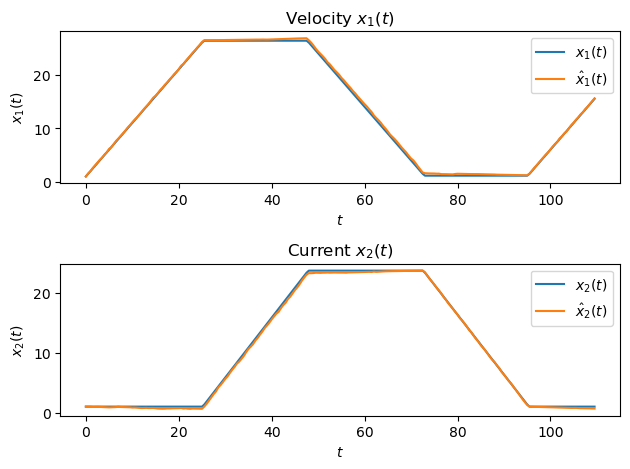

In [1169]:
T = np.arange(0,N*Ts, Ts)


fig=plt.figure()
ax1=plt.subplot(2,1,1)
ax1.plot(T,pose_true[:,0],label=r'$x_1(t)$')
ax1.plot(T,pose_pred[:,0],label=r'$\hat{x}_1(t)$')
# ax1.plot(T,xhatinf[:,0],label=r'$\hat{x}^{\infty}_1(t)$')
plt.xlabel("$t$")
plt.ylabel("$x_1(t)$")
plt.title("Velocity $x_1(t)$")
plt.legend()
ax1=plt.subplot(2,1,2)
ax1.plot(T,pose_true[:,1],label=r'$x_2(t)$')
ax1.plot(T,pose_pred[:,1],label=r'$\hat{x}_2(t)$')
# ax1.plot(T,xhatinf[:,1],label=r'$\hat{x}^{\infty}_2(t)$')
plt.xlabel("$t$")
plt.ylabel("$x_2(t)$")
plt.title("Current $x_2(t)$")
plt.legend()
fig.tight_layout()
plt.show()

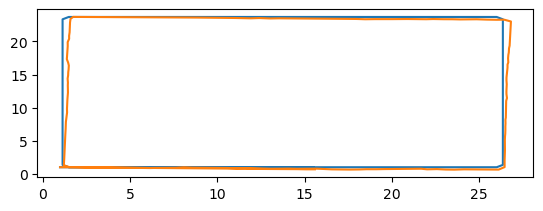

In [1170]:
fig = plt.figure()
ax1=plt.subplot(2,1,1)
ax1.plot(pose_true[:,0],pose_true[:,1],label=r'$x_1(t)$')
ax1.plot(pose_pred[:,0],pose_pred[:,1],label=r'$\hat{x}_1(t)$')
plt.show()


In [1171]:
print(Landmarks)

[[ 4  4]
 [ 8  4]
 [12  4]
 [16  4]
 [20  4]
 [24  4]
 [24  8]
 [24 12]
 [24 16]
 [ 4 20]
 [ 8 20]
 [12 20]
 [16 20]
 [20 20]
 [24 20]
 [ 4  8]
 [ 4 12]
 [ 4 16]]


In [1172]:
print(landmark_pred)
landmark_pred = landmark_pred.reshape(-1,2)
print(landmark_pred)

[ 4.12751     3.93441241  8.124346    3.84440021 12.12804335  3.76082733
 16.12633453  3.67342757 20.1325153   3.57978684 24.13337099  3.49914085
 24.21061222  7.49676914 24.2924707  11.49421197 24.37328055 15.49684282
  4.47226019 19.93497094  8.47171896 19.84989479 12.46621911 19.76731681
 16.46480579 19.6751484  20.46965968 19.5917709  24.46648785 19.49491065
  4.20937608  7.93241235  4.29669552 11.93628342  4.38120869 15.93977782]
[[ 4.12751     3.93441241]
 [ 8.124346    3.84440021]
 [12.12804335  3.76082733]
 [16.12633453  3.67342757]
 [20.1325153   3.57978684]
 [24.13337099  3.49914085]
 [24.21061222  7.49676914]
 [24.2924707  11.49421197]
 [24.37328055 15.49684282]
 [ 4.47226019 19.93497094]
 [ 8.47171896 19.84989479]
 [12.46621911 19.76731681]
 [16.46480579 19.6751484 ]
 [20.46965968 19.5917709 ]
 [24.46648785 19.49491065]
 [ 4.20937608  7.93241235]
 [ 4.29669552 11.93628342]
 [ 4.38120869 15.93977782]]


(18, 2)


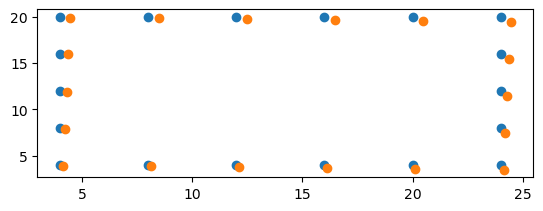

In [1173]:
landmark_pred = landmark_pred.reshape(-1,2)
print(landmark_pred.shape)

fig = plt.figure()
ax1=plt.subplot(2,1,1)
ax1.scatter(Landmarks[:,0],Landmarks[:,1],label=r'$x_1(t)$')
ax1.scatter(landmark_pred[:,0],landmark_pred[:,1],label=r'$\hat{x}_1(t)$')
# plt.scatter(x, y)

plt.show()


In [1174]:
X

array([ 1.55625215e+01,  6.96359955e-01, -2.13069219e-02,  4.12465494e+00,
        3.93723733e+00,  8.12161682e+00,  3.85084892e+00,  1.21252770e+01,
        3.77130276e+00,  1.61235221e+01,  3.68820765e+00,  2.01298711e+01,
        3.59894536e+00,  2.41294694e+01,  3.51945490e+00,  2.42046377e+01,
        7.51723166e+00,  2.42833816e+01,  1.15145816e+01,  2.43608654e+01,
        1.55171766e+01,  4.45585013e+00,  1.99379678e+01,  8.45542380e+00,
        1.98564276e+01,  1.24500811e+01,  1.97773861e+01,  1.64488043e+01,
        1.96886674e+01,  2.04537599e+01,  1.96087449e+01,  2.44506962e+01,
        1.95152614e+01,  4.20300545e+00,  7.93526241e+00,  4.28697792e+00,
        1.19391396e+01,  4.36829137e+00,  1.59427233e+01])

In [1175]:
for i in range(45, 55):
    print(range_land[i])
    print(angle_land[i])
    print(index_land[i])
    print('---------------')

[3.04930366 7.0099234 ]
[1.40538025 1.49717024]
[6 7]
---------------
[3.01271821 6.99880447]
[1.56660412 1.57375007]
[6 7]
---------------
[]
[]
[]
---------------
[]
[]
[]
---------------
[]
[]
[]
---------------
[3.61166357 7.27807386]
[1.37157106 1.06223672]
[6 7]
---------------
[6.88206348 3.53100625 7.06890106]
[1.17586314 0.73458289 0.33875085]
[5 6 7]
---------------
[6.70423651 3.1824019  6.59070753]
[1.24848868 0.83249034 0.36966152]
[5 6 7]
---------------
[6.57499678 2.88227893 6.11315297 9.91797036]
[1.31155856 0.95527507 0.39381955 0.23480688]
[5 6 7 8]
---------------
[6.45507474 2.63286155 5.65751375 9.42548396]
[1.39520892 1.11672522 0.42717809 0.25090904]
[5 6 7 8]
---------------


In [1176]:
#before correction step: dont forget to insert the landmark into state vector the first time. After inserting don't insert the same one again.
# if landmark
#     L_x[i] = blaba
#     L_y[i] = blabla